In [20]:
from src.all_in_one import *
from src.basic_variables import *
from src.analysis_functions import *

In [21]:
td_file = path_manager.get_data_file(Category.PS, PSFile.TD)
td_dataset = Dataset(config_file, td_file.sheet)
td = get_df(td_file.path, td_file.sheet)
filtered_td = filter_dataframe_on_date(td, td_dataset.dvars, START, END, FilterType.IN)

In [5]:
# td.to_clipboard()
# filtered_td

In [4]:
filtered_td.shape

(8, 18)

In [6]:
f_td_new = filter_dataframe_on_date(td, "consult", START, END)
f_td_new.shape

(8, 18)

In [7]:
# Total Number of Sessions
f_td_new_interview_s1 = filter_dataframe_on_date(td, "interview_s1", START, END)
f_td_new_interview_s2 = filter_dataframe_on_date(td, "interview_s2", START, END)
f_td_new_interview_s3 = filter_dataframe_on_date(td, "interview_s3", START, END)

f_td_new_number_of_sessions = (
    f_td_new.shape[0]
    + f_td_new_interview_s1.shape[0]
    + f_td_new_interview_s2.shape[0]
    + f_td_new_interview_s3.shape[0]
)
f_td_new_number_of_sessions

8

In [8]:
# Count TD new client sex distribution
f_td_new_with_sex = pd.merge(
    f_td_new, rebuilt_scr[["rid", "sex", "age"]], on="rid", how="left"
)
f_td_new_with_sex["sex"].value_counts()

sex
Male      4
Female    4
Name: count, dtype: int64

In [9]:
categorize_and_count_ages(f_td_new_with_sex["age"])
# f_td_new_with_sex['age'].head()

age
18-27    0
28-37    3
38-47    3
48-57    2
58-67    0
68-77    0
Name: count, dtype: int64

In [10]:
# Count TD pathways distribution
count_df = f_td_new[td_dataset.bovars].apply(lambda x: x.value_counts()).fillna(0)
count_df = count_df.T.reset_index().rename(columns={"index": "pathways"})  # Transposing
count_df["No"] = count_df["No"].astype("Int64")
count_df["Yes"] = count_df["Yes"].astype("Int64")
count_df

,pathways,No,Yes
0,legal_doc,1,7
1,individual_use,6,2
2,cws,0,8
3,communicat_use,5,3
4,advocacy,1,7


## Creative Wrokshops

In [27]:
# cws_file = path_manager.get_data_file(Category.PS, PSFile.CWS)
# cws_dataset = Dataset(config_file, cws_file.sheet)
# cws = get_df(cws_file.path, cws_file.sheet)
# filtered_cws = filter_dataframe_on_date(cws, cws_dataset.dvars, START, END)
pd.read_csv("data/processed/1224/09_pscws_1224.csv").to_clipboard()

In [20]:
filtered_cws_with_demo = pd.merge(
    filtered_cws, rebuilt_scr[["rid", "sex", "age"]], on="rid", how="left"
)

In [21]:
# Grouping upon dates for sex distribution
filtered_cws_with_demo_grouped = (
    filtered_cws_with_demo.groupby(
        [
            "cws_s1",
            "sex",
        ]
    )
    .size()
    .unstack(fill_value=0)
)
# filtered_cws_with_demo_grouped

## Advocacy

In [29]:
# adv = pd.read_csv(r"data/processed/0924/18_adv_0924.csv")
# filtered_adv = filter_dataframe_on_date(adv, "eventDate", START, END)
# filtered_adv.shape

In [ ]:
filtered_adv["gender"].value_counts()

In [11]:
from upsetplot import UpSet
from upsetplot import UpSet, from_indicators
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning, module="upsetplot")

In [15]:
# new_intake['fcid', td_dataset.bovars]
# fcid = ["fcid"]
# victimhood_df = new_intake.loc[:, fcid + intake_dataset.bovars]
td_pathways = f_td_new[td_dataset.bovars]
td_pathways_columns_names = {
    "legal_doc": "Legal Documentation",
    "individual_use": "Individual Use",
    "cws": "Creative Documentation Workshop",
    "communicat_use": "Communication",
    "advocacy": "Advocacy",
}
td_pathways.rename(columns=td_pathways_columns_names, inplace=True)
td_pathways

,Legal Documentation,Individual Use,Creative Documentation Workshop,Communication,Advocacy
11,Yes,Yes,Yes,No,Yes
12,Yes,Yes,Yes,Yes,Yes
34,Yes,No,Yes,Yes,Yes
58,Yes,No,Yes,Yes,Yes
59,No,No,Yes,No,No
60,Yes,No,Yes,No,Yes
112,Yes,No,Yes,No,Yes
113,Yes,No,Yes,No,Yes


In [17]:
# Convert "Yes"/"No" to boolean (True/False)
boolean_td_df = td_pathways.map(lambda x: x == "Yes")
# boolean_td_df

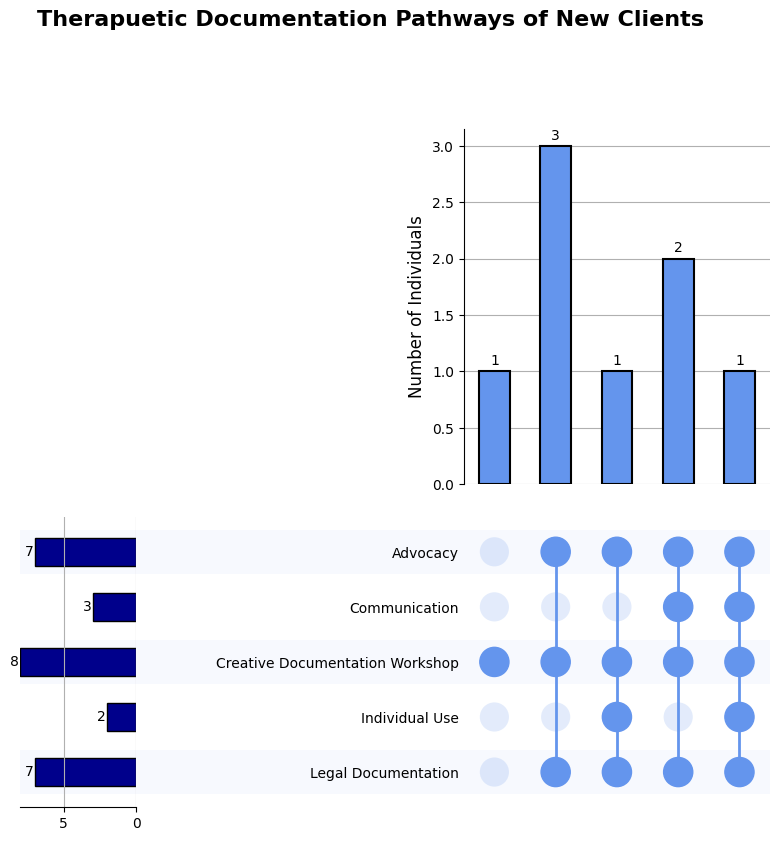

In [18]:
# Create the UpSet plot
upset_data = from_indicators(data=boolean_td_df, indicators=boolean_td_df.columns)
# Use a clean and reliable matplotlib style
plt.style.use("default")

# Create the UpSet plot with detailed customization
upset = UpSet(
    upset_data,
    subset_size="count",  # Display subset sizes as counts
    show_counts=True,  # Show counts on bars
    sort_categories_by=None,  # Keep the original order of categories
    facecolor="cornflowerblue",  # Set bar fill color
    element_size=60,  # Increase the size of the grid and elements
    # intersection_linewidth=1.5,         # Adjust grid line width
    # totals_color="darkblue",            # Set color for totals (left-side bar chart)
)

# Modify the plot after it is generated
fig = upset.plot()

# Customize the intersection bars (manually iterate over artists)
for patch in fig["intersections"].patches:
    patch.set_edgecolor("black")  # Add black borders to the bars
    patch.set_linewidth(1.5)  # Set border line width

# Customize the totals (left-side bars)
for patch in fig["totals"].patches:
    patch.set_facecolor("darkblue")  # Set totals color
    patch.set_edgecolor("black")  # Add black border

# Add a custom title and axis labels
plt.suptitle(
    "Therapuetic Documentation Pathways of New Clients",
    fontsize=16,
    fontweight="bold",
    color="black",
)
plt.xlabel("TD Pathways Combinations", fontsize=11, color="black")
plt.ylabel("Number of Individuals", fontsize=12, color="black")

# Customize tick labels and fonts
plt.xticks(
    fontsize=10, rotation=45, ha="right"
)  # Rotate x-axis labels for better visibility
plt.yticks(fontsize=10)

# Adjust layout to prevent overlapping
plt.subplots_adjust(top=0.85, left=0.15, right=0.9)

# Display the plot
plt.show()